In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup environment

In [2]:
!pip install monai-weekly
!pip install tqdm
#!pip install pytorch-ignite
#!pip install tmp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00


In [3]:
import logging
import os
import sys
import time
import glob
import tqdm
#import shutil

import matplotlib.pyplot as plt
import torch
import numpy as np
#import pandas as pd
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset, Dataset, decollate_batch
from monai.data import (
    ArrayDataset, GridPatchDataset, PatchIter)
from monai.utils import first
from monai.transforms import (
    #ResizeWithPadOrCropd,
    #RandFlipd,
    #EnsureChannelFirst,
    EnsureChannelFirstd,
    AsDiscrete,
    SpatialCropd,
    #RandCropByPosNegLabeld,
    RandSpatialCropd,
    #RandSpatialCropSamplesd,
    #CropForeground,
    #CropForegroundd,
    #RandGaussianNoised,
    #Spacing,
    #Spacingd,
    #AddChannel,
    Compose,
    LoadImage,
    #Resize,
    EnsureType,
    #Randomizable,
    LoadImaged,
    EnsureTyped,
    AddChanneld,
    #RandAffined,
    #Resized,
    #RandShiftIntensityd,
    #ScaleIntensityRanged,
    #ScaleIntensityRange,
    #MapTransform,
    CenterSpatialCropd,
    #Orientationd,
    #Invertd,
    #AsDiscreted,
    NormalizeIntensityd,
    ToTensord,
)

from monai.data import DataLoader, CacheDataset, DataLoader, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric #,compute_meandice
from monai.networks.nets import UNet
from monai.utils import set_determinism, first
from monai.inferers import sliding_window_inference
#from monai.handlers.utils import from_engine

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.3.dev2333
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c894f452aca62cac1ff053c150aa8805a22ee65f
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optiona

In [12]:
root_dir = '/content/drive/MyDrive/HUFS/Digital_image_processing/project'
model_dir = '/content/drive/MyDrive/HUFS/Digital_image_processing/project/model'

data_dir = os.path.join(root_dir, "brats18_train")
if os.path.exists(root_dir):
  print("경로 존재")
else:
  print("경로 존재x")

print(data_dir)

경로 존재
/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train


In [13]:
# train data와 validation data만들기

train_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_*", "t1ce.nii.gz"))) # image data에 대한 경로만 전부 sorting 해서 리스트 형식으로 저장
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_*", "label.nii.gz"))) # label data에 대한 경로만 전부 sorting 해서 리스트 형식으로 저장
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)  # 모든 데이터들의 경로를 image와 label pair를 딕셔너리 형태로 만들어준다
]

train_files = []
val_files = []
for i in range(len(data_dicts)):
  if i % 5 == 0:
    val_files.append(data_dicts[i])
  else :
    train_files.append(data_dicts[i])

# 전체 데이터에 대해 train_files과 val_file로 비율을 설정하여 나누어 준다(80:20)

In [14]:
print(f'train_images number : {len(train_images)}')
print(f'train_labels number : {len(train_labels)}')

print(f'train_files number : {len(train_files)}')
print(train_files[:5])
print(f'val_files number : {len(val_files)}')
print(val_files[:5])

train_images number : 100
train_labels number : 100
train_files number : 80
[{'image': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_13_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_13_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_17_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_17_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_19_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_19_1/label.nii.gz'}, {'image': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2013_21_1/t1ce.nii.gz', 'label': '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_train/Brats18_2

In [15]:
set_determinism(seed=0)

## 데이터 전처리

히스토그램 평활화 (histogram_equalization)

https://gaussian37.github.io/vision-concept-histogram_equalization/

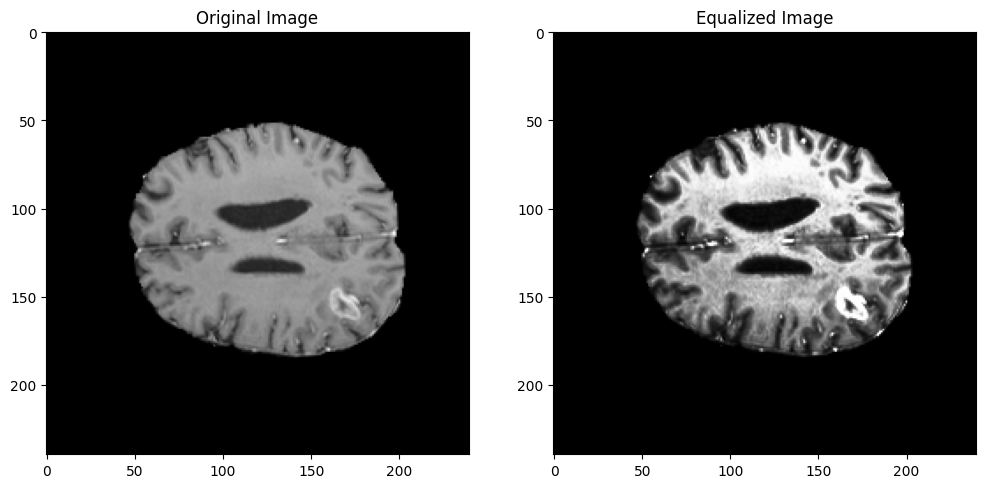

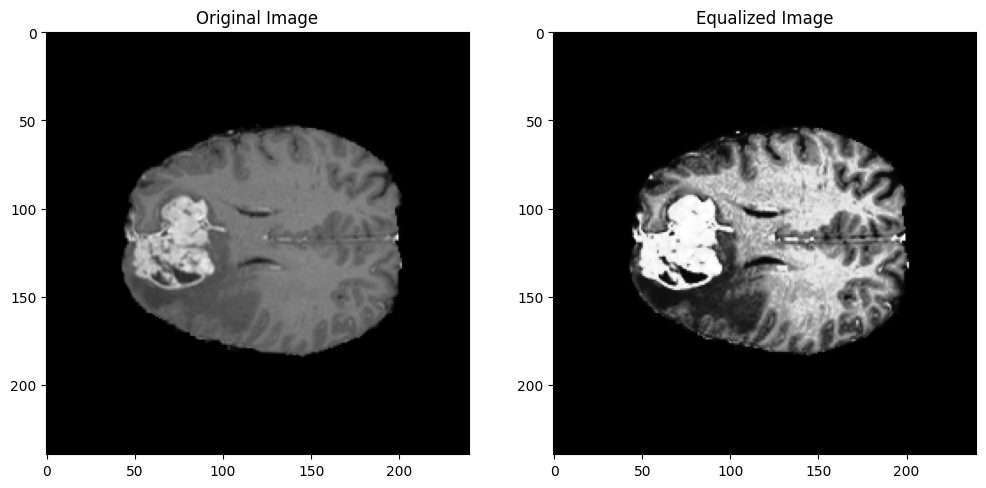

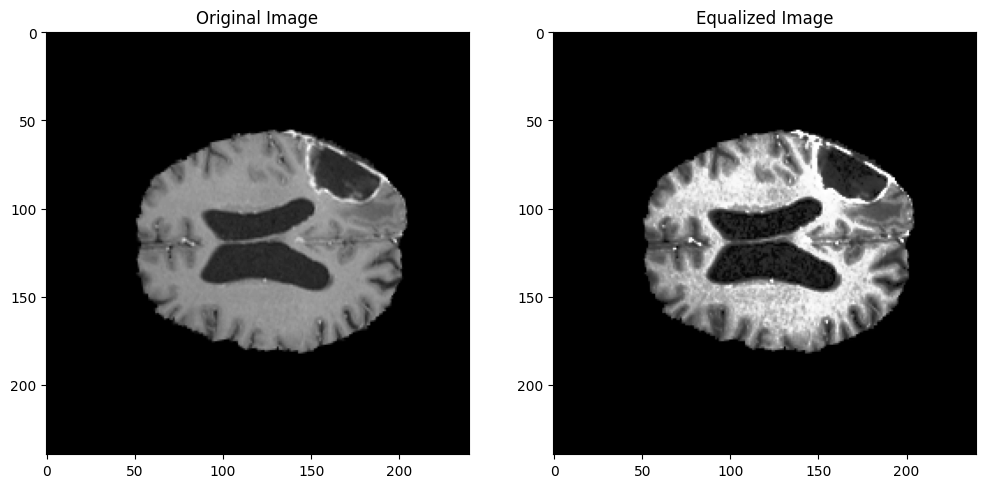

In [81]:
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

for i in range(3):
    nifti_image = nib.load(train_files[i]['image'])  # 파일 경로를 적절하게 지정

    # 이미지 데이터 추출
    image_data = nifti_image.get_fdata()

    # 이미지 정규화
    normalized_image = ((image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255).astype(np.uint8)

    # 이미지 히스토그램 평활화
    equalized_image = np.zeros_like(normalized_image)
    for i in range(normalized_image.shape[2]):
        equalized_image[:, :, i] = cv2.equalizeHist(normalized_image[:, :, i])

    # 원본 이미지 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(normalized_image[:, :, 96], cmap="gray")  # 중간 단면 이미지 시각화

    # 평활화된 이미지 시각화
    plt.subplot(1, 2, 2)
    plt.title("Equalized Image")
    plt.imshow(equalized_image[:, :, 96], cmap="gray")  # 중간 단면 이미지 시각화

    plt.show()

transforms 정의


In [15]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        CenterSpatialCropd(keys=["image", "label"], roi_size = [224,224,96],),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        RandSpatialCropd(keys=["image","label"], roi_size = [224,224,96], random_size = False),
        EnsureChannelFirstd(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([224, 224, 96]), label shape: torch.Size([224, 224, 96])


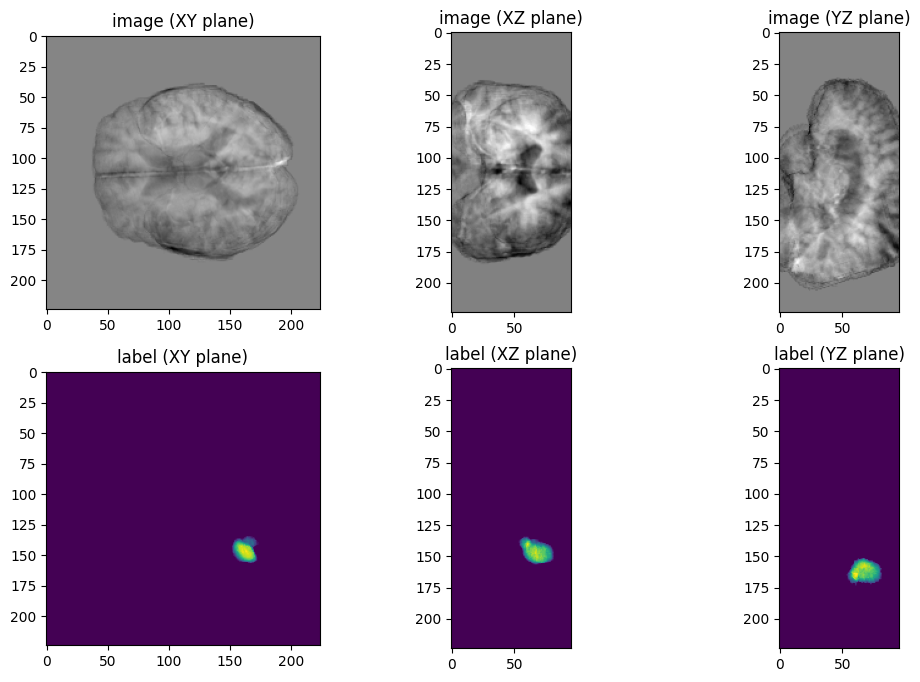

image shape: torch.Size([224, 224, 96]), label shape: torch.Size([224, 224, 96])


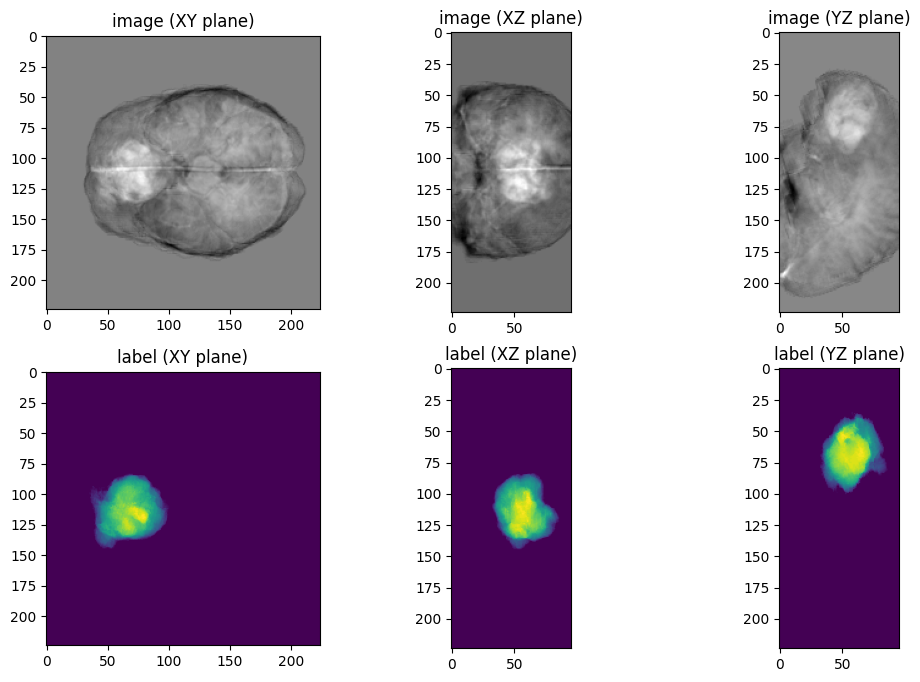

image shape: torch.Size([224, 224, 96]), label shape: torch.Size([224, 224, 96])


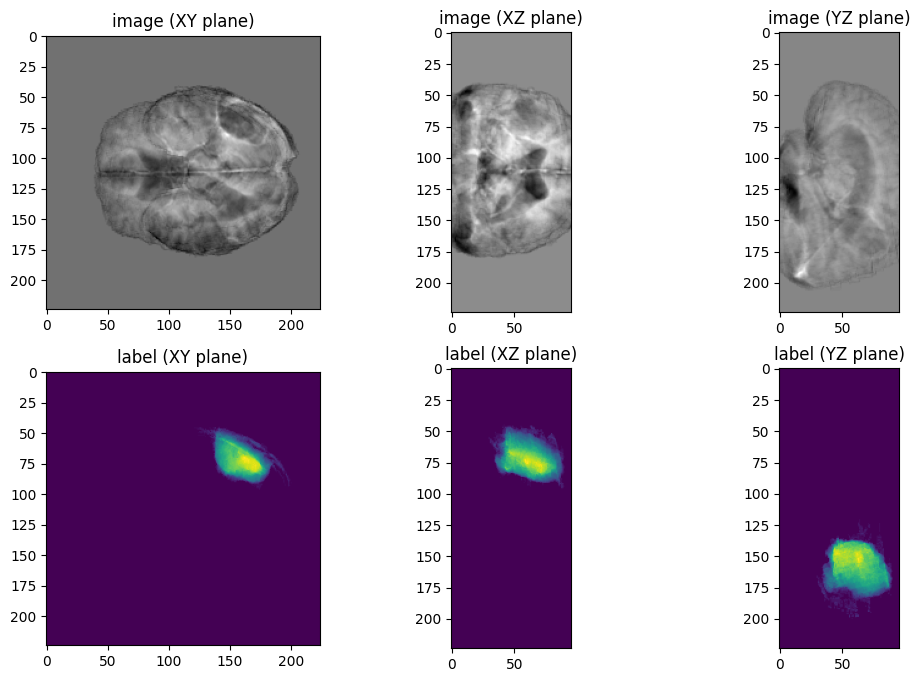

image shape: torch.Size([224, 224, 96]), label shape: torch.Size([224, 224, 96])


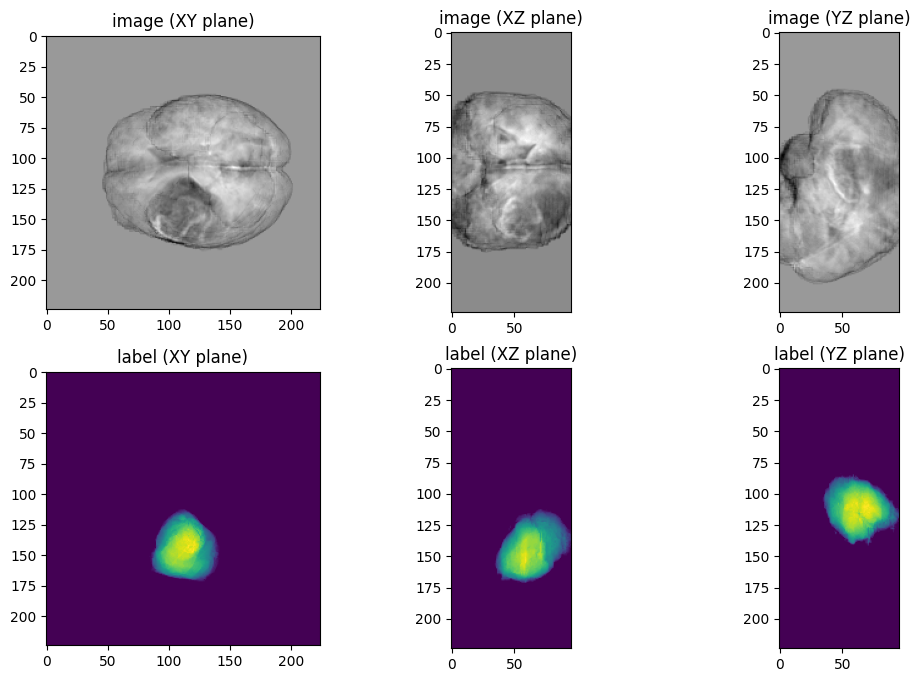

In [75]:
check_ds = Dataset(data=train_files[:4], transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for check_data in check_loader:
  image = check_data["image"].squeeze()  # [1, 1, 224, 224, 96] -> [224, 224, 96]
  label = check_data["label"].squeeze()  # [1, 1, 224, 224, 96] -> [224, 224, 96]

  # 이미지와 레이블의 형태 출력
  print(f"image shape: {image.shape}, label shape: {label.shape}")

  # 이미지와 레이블 시각화
  plt.figure("check", (12, 8))

  plt.subplot(2, 3, 1)
  plt.title("image (XY plane)")
  plt.imshow(torch.sum(image, axis=2), cmap="gray")

  plt.subplot(2, 3, 2)
  plt.title("image (XZ plane)")
  plt.imshow(torch.sum(image, axis=1), cmap="gray")

  plt.subplot(2, 3, 3)
  plt.title("image (YZ plane)")
  plt.imshow(torch.sum(image, axis=0), cmap="gray")

  plt.subplot(2, 3, 4)
  plt.title("label (XY plane)")
  plt.imshow(torch.sum(label, axis=2))

  plt.subplot(2, 3, 5)
  plt.title("label (XZ plane)")
  plt.imshow(torch.sum(label, axis=1),)

  plt.subplot(2, 3, 6)
  plt.title("label (YZ plane)")
  plt.imshow(torch.sum(label, axis=0),)

  plt.show()

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


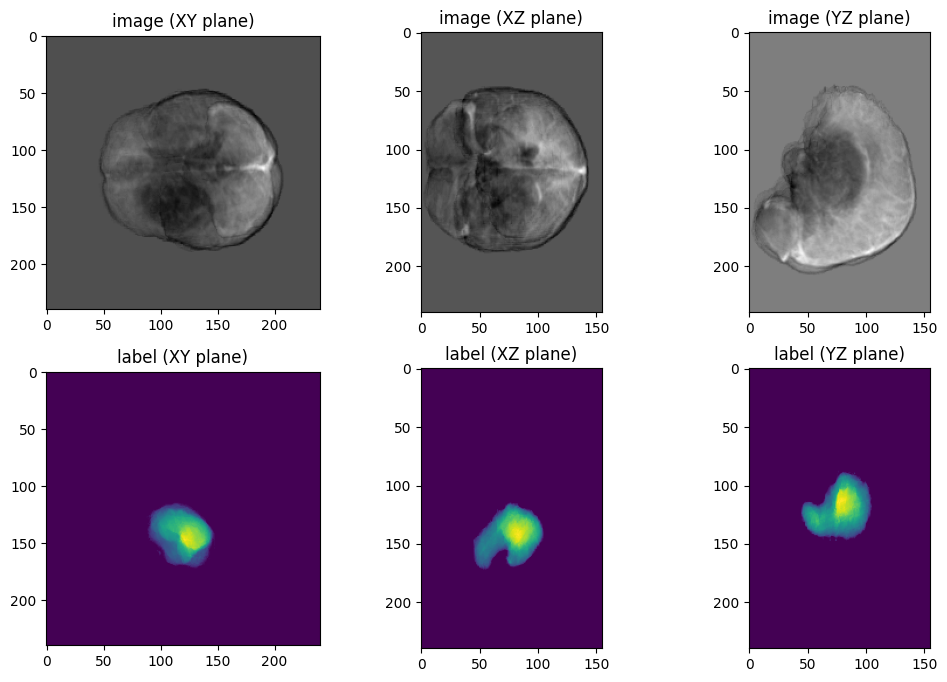

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


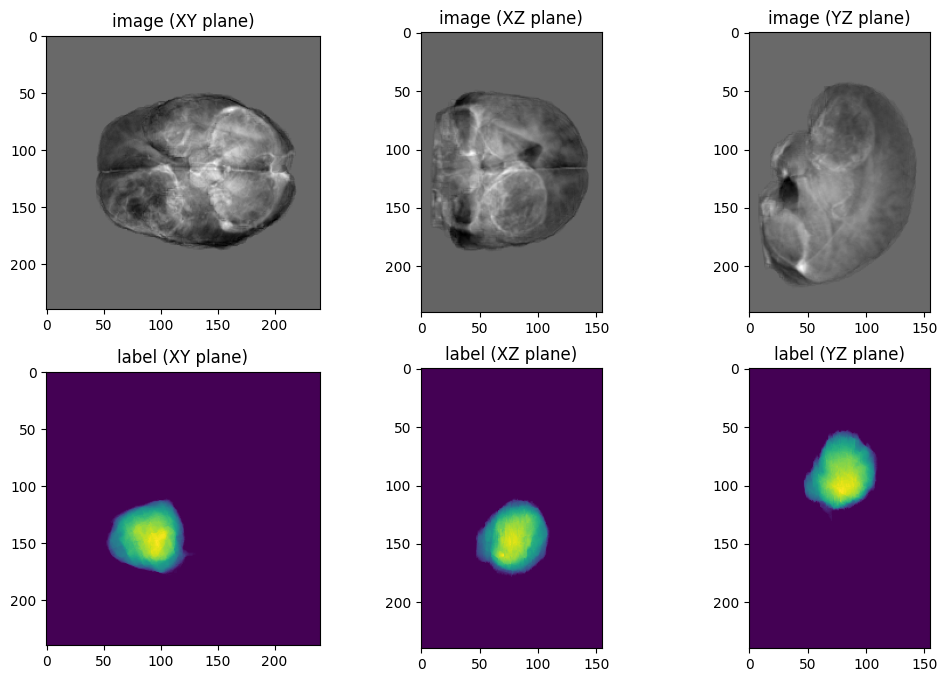

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


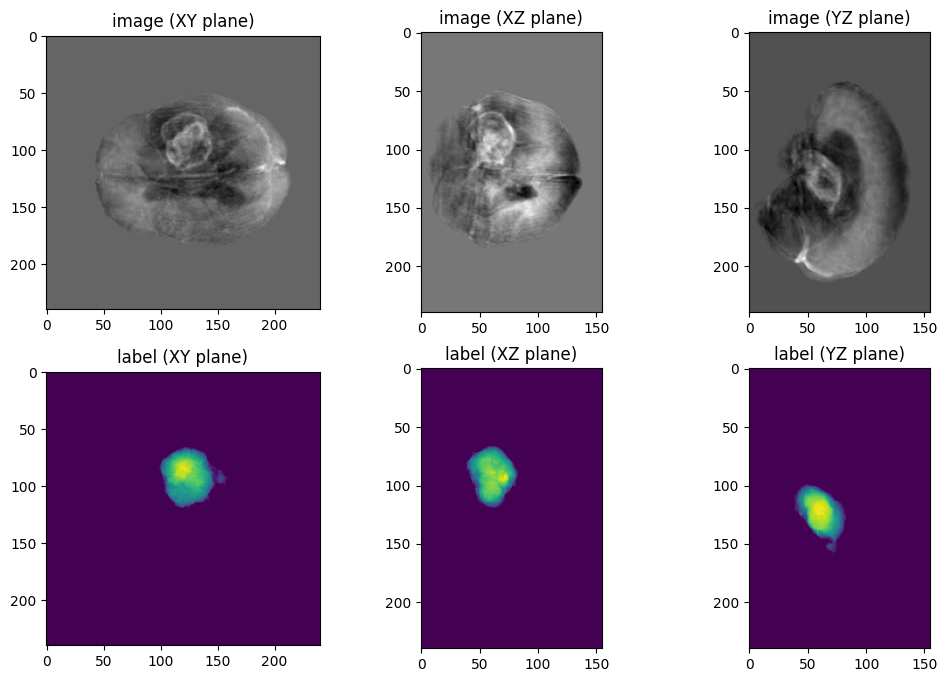

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


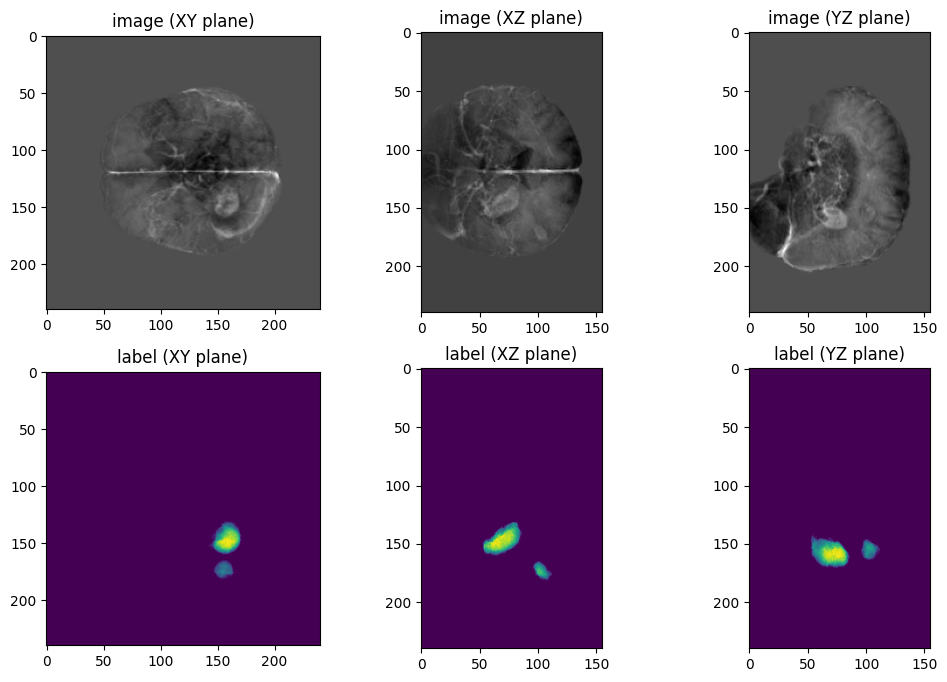

In [76]:
check_ds = Dataset(data=val_files[:4], transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for check_data in check_loader:
  image = check_data["image"].squeeze()  # [1, 1, 224, 224, 96] -> [224, 224, 96]
  label = check_data["label"].squeeze()  # [1, 1, 224, 224, 96] -> [224, 224, 96]

  # 이미지와 레이블의 형태 출력
  print(f"image shape: {image.shape}, label shape: {label.shape}")

  # 이미지와 레이블 시각화
  plt.figure("check", (12, 8))

  plt.subplot(2, 3, 1)
  plt.title("image (XY plane)")
  plt.imshow(torch.sum(image, axis=2), cmap="gray")

  plt.subplot(2, 3, 2)
  plt.title("image (XZ plane)")
  plt.imshow(torch.sum(image, axis=1), cmap="gray")

  plt.subplot(2, 3, 3)
  plt.title("image (YZ plane)")
  plt.imshow(torch.sum(image, axis=0), cmap="gray")

  plt.subplot(2, 3, 4)
  plt.title("label (XY plane)")
  plt.imshow(torch.sum(label, axis=2))

  plt.subplot(2, 3, 5)
  plt.title("label (XZ plane)")
  plt.imshow(torch.sum(label, axis=1),)

  plt.subplot(2, 3, 6)
  plt.title("label (YZ plane)")
  plt.imshow(torch.sum(label, axis=0),)

  plt.show()

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


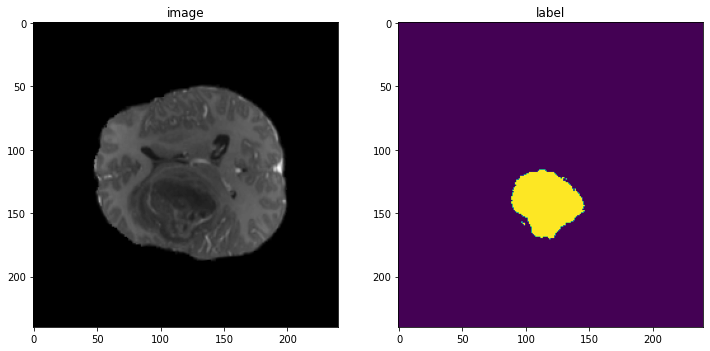

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
zz = np.argmax(np.sum(np.sum(np.array(label),axis=1),axis=0))
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:,zz], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:,:,zz])
plt.show()

In [16]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████| 80/80 [01:04<00:00,  1.25it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


모델 학습

In [18]:
from monai.networks.layers import Norm

# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

model = UNet(
    #dimensions=3,
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

working on cpu


In [24]:
model.load_state_dict(torch.load(f'{model_dir}/best_metric_model.pth'), map_location=torch.device("cuda:0"))

In [118]:
import gc

def setting_device_status():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("working on gpu")
    else:
        device = torch.device("cpu")
        print("working on cpu")

def empty_cache():
    gc.collect()
    torch.cuda.empty_cache()

!nvidia-smi
empty_cache()

In [ ]:
max_epochs = 200  # epochs수
val_interval = 2 # validation interval
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = [] # epoch 마다 계산되는 loss값 기록 리스트
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2, n_classes=2)]) #
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2, n_classes=2)]) #

for epoch in range(max_epochs):
    stime = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() # 모듈을 training mode로 설정.
    epoch_loss = 0 # epoch loss값 저장
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        inputs = torch.squeeze(inputs, dim=2)
        labels = torch.squeeze(labels, dim=2)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # parameter 업데이트
        epoch_loss += loss.item() # average loss를 구하기 위해 해당 epoch에서 구한 loss를 더해줌
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step # average loss 계산
    epoch_loss_values.append(epoch_loss) # epoch average loss 를 저장 해놓는 list에 추가
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0: # 짝수 번째 epoch에서 모델 vlaidation
        model.eval() # 모듈을 evaluation mode로 설정(계산에 필요한 메모리 소모량을 줄일 수 있음)
        with torch.no_grad(): # gradinet 계산하지 않음(when you are surethat you will not call Tensor.backward())
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (64, 64, 32)
                sw_batch_size = 4         #window slices를 실행할 batch size.
                val_outputs = sliding_window_inference(         #validation output
                    val_inputs, roi_size, sw_batch_size, model)
                # sliding_window_inference : patch를 이용해 모델을 학습한 후에, 그 모델을 활용할 때에는 patch에 대한 결과가 아니라
                                                    # 전체 영상에 대한 결과를 얻는 것을 원합니다.
                                                    # 큰 영상데이터를 patch단위로 결과를 보는 것을 쉽게 해주는 함수.
                                                    # window는 patch라고 보면 됩니다
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            print(f"metric : {metric}")
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:       # 현재 mean dice result가 가장 좋다면 best_metric으로 저장
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join( # 지정해준 PATH에 최상의 dice 값에 대한 모델 weight를 파일에 저장
                    model_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"

            )
    print(f"1 epoch time : {(time.time() - stime) / 60} min")

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))] # x축 범위
y = epoch_loss_values # y 좌표 값
plt.xlabel("epoch") # x축 이름
plt.plot(x, y) # plot
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))] # x축 범위
y = metric_values # y 좌표 값
plt.xlabel("epoch")
plt.plot(x, y) # plot
plt.show() # 모든 Figure를 display
plt.savefig(f"{root_dir}/the_loss_and_metric.png")

* validation inference

In [ ]:
import nibabel as nib

In [ ]:
flag_niisav = 0

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )

        plt.figure("check", (18, 6))
        plt.subplot(2, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        plt.subplot(2, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 3, 4)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        plt.subplot(2, 3, 5)
        plt.title(f"label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=0),aspect=1/4)
        plt.subplot(2, 3, 6)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)
        plt.show()

        plt.figure("check", (12, 8))

        plt.subplot(2, 3, 1)
        plt.title("image (XY plane)")
        plt.imshow(torch.sum(image, axis=2), cmap="gray")

        plt.subplot(2, 3, 2)
        plt.title("image (XZ plane)")
        plt.imshow(torch.sum(image, axis=1), cmap="gray")

        plt.subplot(2, 3, 3)
        plt.title("image (YZ plane)")
        plt.imshow(torch.sum(image, axis=0), cmap="gray")

        plt.subplot(2, 3, 4)
        plt.title("label (XY plane)")
        plt.imshow(torch.sum(label, axis=2))

        plt.subplot(2, 3, 5)
        plt.title("label (XZ plane)")
        plt.imshow(torch.sum(label, axis=1),)

        plt.subplot(2, 3, 6)
        plt.title("label (YZ plane)")
        plt.imshow(torch.sum(label, axis=0),)

        if flag_niisav == 1:
            outdir='/content/drive/MyDrive/nifti_save/'
            print(outdir)

            h0 = nib.Nifti1Image(val_data['image'][0,0].cpu().numpy(),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h0,os.path.join(outdir,f'IMAGE.nii.gz'))
            h1 = nib.Nifti1Image(val_outputs.cpu().softmax(1)[0,1].numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h1,os.path.join(outdir,f'LABEL.nii.gz'))
            h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h2,os.path.join(outdir,f'OUTPUT.nii.gz'))
        if i==2:
            break

In [ ]:
flag_niisav = 0

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        print(torch.sum(val_data["image"][0, 0]).shape)
        print(torch.argmax(val_outputs[0], dim=0).cpu().shape)
        plt.figure("check", (18, 18))

        plt.subplot(3, 3, 1)
        plt.title(f"Input Image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0], dim=0), cmap="gray", aspect=1/4)

        plt.subplot(3, 3, 2)
        plt.title(f"Ground Truth Label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0], dim=0), aspect=1/4)

        plt.subplot(3, 3, 3)
        plt.title(f"Predicted Output {i}")
        #plt.imshow(torch.argmax(val_outputs[0], dim=0).cpu(), aspect=1/4)
        slice_idx = 100
        plt.imshow(torch.argmax(val_outputs[0, :, :, :, slice_idx].cpu(), dim=0), aspect=1/4)

        plt.subplot(3, 3, 4)
        plt.title(f"Input Image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0], dim=1), cmap="gray", aspect=1/4)

        plt.subplot(3, 3, 5)
        plt.title(f"Ground Truth Label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0], dim=1), aspect=1/4)

        plt.subplot(3, 3, 6)
        plt.title(f"Predicted Output {i}")
        plt.imshow(torch.argmax(val_outputs[0], dim=1).cpu(), aspect=1/4)

        plt.subplot(3, 3, 7)
        plt.title(f"Input Image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0], dim=2), cmap="gray", aspect=1/4)

        plt.subplot(3, 3, 8)
        plt.title(f"Ground Truth Label {i}")
        plt.imshow(torch.amax(val_data["label"][0, 0], dim=2), aspect=1/4)

        plt.subplot(3, 3, 9)
        plt.title(f"Predicted Output {i}")
        plt.imshow(torch.argmax(val_outputs[0], dim=2).cpu(), aspect=1/4)

        plt.show()

        if flag_niisav == 1:
            outdir='/content/drive/MyDrive/nifti_save/'
            print(outdir)

            h0 = nib.Nifti1Image(val_data['image'][0,0].cpu().numpy(),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h0,os.path.join(outdir,f'IMAGE.nii.gz'))
            h1 = nib.Nifti1Image(val_outputs.cpu().softmax(1)[0,1].numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h1,os.path.join(outdir,f'LABEL.nii.gz'))
            h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
            nib.save(h2,os.path.join(outdir,f'OUTPUT.nii.gz'))
        if i==2:
            break

# test

In [ ]:
data_dir = '/content/drive/MyDrive/HUFS/Digital_image_processing/project/brats18_test'

save_dir = '/content/drive/MyDrive/nifti_save2/'

import os

if os.path.exists(data_dir):    # 지정된 경로가 존재하는지 여부를 확인
    print("경로 존재")
else:
    print("경로 존재X")

경로 존재


In [ ]:
# test_set 준비

test_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_test_*", "t1ce.nii.gz")))

test_files = [
    {"image": image_name}
    for image_name in (test_images)
]

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

test_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

dice_metric = DiceMetric(include_background=False, reduction="mean")

# evaluation

model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        plt.figure("check", (18, 6))
        plt.subplot(2, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        plt.subplot(2, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 2, 3)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        plt.subplot(2, 2, 4)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)
        plt.show()

        # output파일 저장
        h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
        nib.save(h2,os.path.join(save_dir,f"{test_files[i].get('image').split('/')[-2]}.nii.gz"))